In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [2]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [3]:
def potential(x,k,l,scale=100):
    poten=-1/x*scale
    return poten-k*(l+1)*l/x**2

In [4]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

###### 氢原子能级
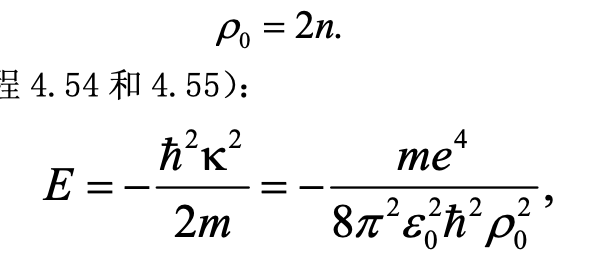
##### 相当于$\alpha=e^2/(4\pi \epsilon_0)=1,E_n=-2m/\hbar^2*\alpha^2/(4n^2)$
##### and $ a_{bohr}=2*k/\alpha, k=\hbar^2/2m $

In [5]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10
en_num=20
epoch=5000
lr=0.01

l2_reg=0
d2_reg=1e-1

real_en=energy(en_num,l,b_lap,scale,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([-49.2425, -12.4515,  -5.5459,  -3.1220,  -1.9987,  -1.3883,  -1.0201,
         -0.7810,  -0.6171,  -0.4998,  -0.4131,  -0.3470,  -0.2957,  -0.2550,
         -0.2218,  -0.1953,  -0.1729,  -0.1540,  -0.1383,  -0.1241],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [6]:
def regular_loss(model,grid):
    loss=0
    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            loss+=torch.nn.MSELoss()(param,torch.zeros_like(param))
    return loss

In [7]:
def dd_loss(model,grid):
    potential=model(grid)
    grad_1=torch.autograd.grad(potential,grid,grad_outputs=torch.ones_like(potential),create_graph=True)[0]
    grad_2=torch.autograd.grad(grad_1,grid,grad_outputs=torch.ones_like(potential),create_graph=True)[0]
    
    dd_loss=torch.nn.MSELoss()(grad_2,torch.zeros_like(grad_2))
    
    return dd_loss

In [8]:

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num])
    print(real_en)
    
    output=eigenvalues[:en_num]
    
    re_loss=regular_loss(model,grid)
    val_loss=loss_fn(output,real_en)
    d2_loss=dd_loss(model,grid)
    
    loss=val_loss+re_loss*l2_reg+d2_loss*d2_reg
    
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')



epoch: 0
tensor([0.5623, 0.8577, 1.0777, 1.2579, 1.4136, 1.5524, 1.6792, 1.7968, 1.9071,
        2.0117, 2.1114, 2.2071, 2.2993, 2.3884, 2.4748, 2.5589, 2.6409, 2.7210,
        2.7994, 2.8761], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-50.0000, -12.5000,  -5.5556,  -3.1250,  -2.0000,  -1.3889,  -1.0204,
         -0.7812,  -0.6173,  -0.5000,  -0.4132,  -0.3472,  -0.2959,  -0.2551,
         -0.2222,  -0.1953,  -0.1730,  -0.1543,  -0.1385,  -0.1250],
       device='cuda:0')
epoch:0,loss:5.950092792510986,time:0.2065114974975586,lr:0.01

epoch: 1
tensor([-23.3465, -22.8347, -22.4157, -22.0455, -21.7072, -21.3918, -21.0944,
        -20.8114, -20.5404, -20.2794, -20.0274, -19.7831, -19.5456, -19.3143,
        -19.0886, -18.8679, -18.6519, -18.4402, -18.2324, -18.0283],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-50.0000, -12.5000,  -5.5556,  -3.1250,  -2.0000,  -1.3889,  -1.0204,
         -0.7812,  -0.6173,  -0.5000,  -0.4132,  -0.3472,  -0.2959,  -0.2551,
         

/opt/miniconda/envs/pubpy/lib/python3.11/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



epoch: 2
tensor([-7.3789, -7.1426, -6.9491, -6.7782, -6.6221, -6.4767, -6.3395, -6.2091,
        -6.0842, -5.9641, -5.8481, -5.7357, -5.6265, -5.5201, -5.4164, -5.3151,
        -5.2159, -5.1188, -5.0235, -4.9300], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-50.0000, -12.5000,  -5.5556,  -3.1250,  -2.0000,  -1.3889,  -1.0204,
         -0.7812,  -0.6173,  -0.5000,  -0.4132,  -0.3472,  -0.2959,  -0.2551,
         -0.2222,  -0.1953,  -0.1730,  -0.1543,  -0.1385,  -0.1250],
       device='cuda:0')

epoch: 3
tensor([0.0680, 0.3420, 0.5413, 0.6996, 0.8324, 0.9480, 1.0513, 1.1455, 1.2324,
        1.3137, 1.3903, 1.4629, 1.5322, 1.5987, 1.6627, 1.7245, 1.7843, 1.8424,
        1.8990, 1.9541], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-50.0000, -12.5000,  -5.5556,  -3.1250,  -2.0000,  -1.3889,  -1.0204,
         -0.7812,  -0.6173,  -0.5000,  -0.4132,  -0.3472,  -0.2959,  -0.2551,
         -0.2222,  -0.1953,  -0.1730,  -0.1543,  -0.1385,  -0.1250],
       device='cuda:0')

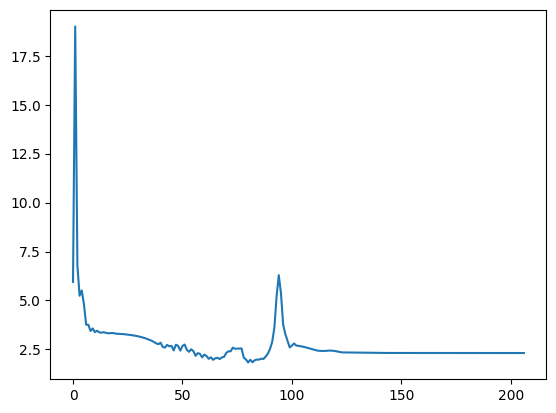

In [9]:
plt.plot(loss_list)
plt.show()

/tmp/ipykernel_3085903/2527805448.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NN_poten_con=torch.load(f'./NN_poten_{lr}_{en_num}.pth')


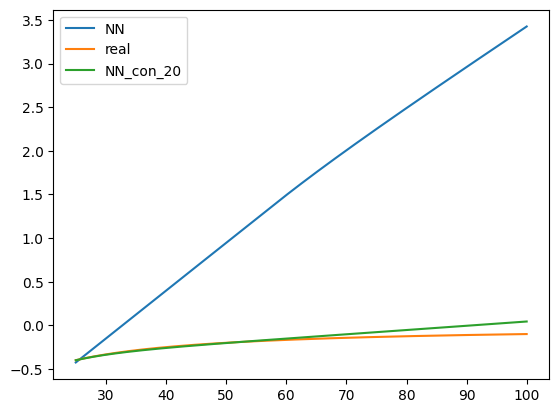

In [10]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[1000:]
NN_poten=model(grid)

NN_poten_con=torch.load(f'./NN_poten_{lr}_{en_num}.pth')

real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
NN_poten_con=NN_poten_con.cpu().detach().numpy()

grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.plot(grid,NN_poten_con[900:],label='NN_con_20')
plt.legend()
plt.show()
